In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

In [16]:
#function for turning the label into
#a variable that categorizes whether an image
#is a letter or not
def letter_or_not(x):
    if x == 'a' or x == 'j':
        return 'letter'
    else:
        return x

In [17]:
#Pull the data from the .csv and remove unnecessary dimensionality
df = pd.read_csv('40431475_features.csv')

keepRows = ["a","j","smiley","sad","xclaim"]
df = df[df['label'].isin(keepRows)]

df['label'] = df['label'].apply(letter_or_not)

x = df[['rows_with_1','cols_with_1','no_neigh_below','no_neigh_right']]
y = df['label']

In [18]:
#Iterate through and store the accuracy of a knn model trained of the data with a specifick value
accs = []

for k in [1,3,5,7,9,11,13]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x,y)
    predicts = knn.predict(x)

    acc = accuracy_score(y,predicts)
    accs.append(acc)

print(accs)

[1.0, 0.868421052631579, 0.868421052631579, 0.8552631578947368, 0.8289473684210527, 0.7894736842105263, 0.7894736842105263]


In [19]:
#Set up variables for storing the accuracy, confusion matrices and error rates for best/different values of k
np.random.seed(42)
avg_accs = []

best_conf_mat = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
best_avg_acc = 0

avg_train_error_rates = []
avg_test_error_rates = []

#set kFolds
kFolds = 5
kf = KFold(n_splits=kFolds, shuffle=True, random_state=42)

In [20]:
#Iterate through each value of k
#Perform crossvalidation
#Save the best model, average accuracy and confusion matrix from each crossvalidation
#Calculate and store the error rates for the graph later
for k in [1,3,5,7,9,11,13]:
    acc_scores = []
    test_error_rates = []
    train_error_rates = []

    total_conf_mat = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])

    for train_idx, test_idx in kf.split(df):
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]

        x_train = train_data[['rows_with_1','cols_with_1','no_neigh_below','no_neigh_right']]
        y_train = train_data['label']
        x_test = test_data[['rows_with_1', 'cols_with_1', 'no_neigh_below', 'no_neigh_right']]
        y_test = test_data['label']

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train,y_train)

        acc = knn.score(x_test, y_test)
        acc_scores.append(acc)

        test_predicts = knn.predict(x_test)
        train_predicts = knn.predict(x_train)

        train_error_rate = 1-accuracy_score(y_train,train_predicts)
        test_error_rate = 1-accuracy_score(y_test,test_predicts)
        train_error_rates.append(train_error_rate)
        test_error_rates.append(test_error_rate)

        classes = ['letter', 'smiley', 'sad', 'xclaim']
        conf_mat = confusion_matrix(y_test,test_predicts, labels=classes)
        for x in range(4):
            for y in range(4):
                total_conf_mat[x,y] = total_conf_mat[x,y] + conf_mat[x,y]
    avg_acc = np.mean(acc_scores)
    avg_accs.append(avg_acc)
    avg_train_error_rate = np.mean(train_error_rates)
    avg_test_error_rate = np.mean(test_error_rates)
    avg_test_error_rates.append(avg_test_error_rate)
    avg_train_error_rates.append(avg_train_error_rate)

    if best_avg_acc < avg_acc:
        best_avg_acc = avg_acc
        best_conf_mat = total_conf_mat

[[16  0  0  0]
 [ 0 12  8  0]
 [ 0  4 16  0]
 [ 1  0  0 19]]
K =  1  Cross-validated accuracy:  0.765
K =  3  Cross-validated accuracy:  0.8283333333333335
K =  5  Cross-validated accuracy:  0.7891666666666668
K =  7  Cross-validated accuracy:  0.775
K =  9  Cross-validated accuracy:  0.7883333333333333
K =  11  Cross-validated accuracy:  0.7491666666666668
K =  13  Cross-validated accuracy:  0.7108333333333333


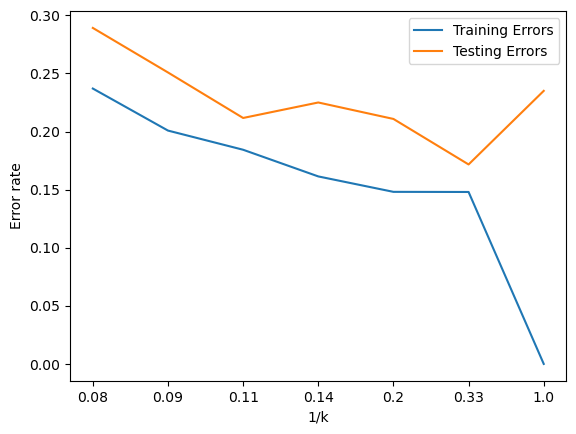

In [21]:
#Display the best confusion matrix and a graph of the results
print(best_conf_mat)
x = [1,3,5,7,9,11,13]
for i in range(7):
    print("K = ",x[i]," Cross-validated accuracy: ",avg_accs[i])

x.reverse()
labels = []
for i in range(len(x)):
    labels.append(str(round(1/x[i],2)))
labels.reverse()
plt.plot(x,avg_train_error_rates, label = 'Training Errors')
plt.plot(x,avg_test_error_rates, label = 'Testing Errors')
plt.legend(loc="upper right")
plt.xlabel("1/k")
plt.ylabel("Error rate")
plt.xticks(x,labels)
plt.show()